# Concentration de CO2 dans l'atmosphère depuis 1958

In [48]:
import os
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fftpack import fft, fftfreq

%matplotlib inline

Dans un premier temps, nous vérifions que le fichier de données local est présent, sinon nous le téléchargeons depuis l'URL.

In [49]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"
data_file = "weekly_in_situ_co2_mlo.csv"

if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Les données sont ensuite chargées à l'aide de pandas.

In [53]:
raw_data = pd.read_csv(data_file, skiprows=44, names=["Date", "CO2"])

new_data = raw_data.copy()
new_data.set_index("Date", drop=True, inplace=True)             
new_data.index = pd.to_datetime(new_data.index, format="%Y-%m-%d")

new_data.head()

CO2
Date              
1958-03-29  316.19
1958-04-05  317.31
1958-04-12  317.69
1958-04-19  317.58
1958-04-26  316.48

Nous vérifions la présence de données potentiellement manquantes mais également si il n'y a pas de semaines manquantes lors des relevés normalement hebdomadaires.

In [4]:
new_data[new_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [CO2]
Index: []

In [5]:
dates = new_data.index
missing_weeks = 0
delta_days = [0]
for dt1, dt2 in zip(dates[:-1], dates[1:]):
    delta = dt2 - dt1
    delta_days.append(delta.days)
    if delta > pd.Timedelta("7d"):
        print("From: {0:} To: {1:} Missing: {2:} days".format(dt1, dt2, delta.days))
        missing_weeks += (delta.days-7)/7
print("Total week missing: {0:}".format(missing_weeks))

From: 1958-05-03 00:00:00 To: 1958-05-17 00:00:00 Missing: 14 days
From: 1958-05-24 00:00:00 To: 1958-07-05 00:00:00 Missing: 42 days
From: 1958-08-16 00:00:00 To: 1958-08-30 00:00:00 Missing: 14 days
From: 1958-09-06 00:00:00 To: 1958-11-08 00:00:00 Missing: 63 days
From: 1959-01-31 00:00:00 To: 1959-02-14 00:00:00 Missing: 14 days
From: 1959-03-07 00:00:00 To: 1959-03-21 00:00:00 Missing: 14 days
From: 1959-05-23 00:00:00 To: 1959-06-06 00:00:00 Missing: 14 days
From: 1959-08-08 00:00:00 To: 1959-08-22 00:00:00 Missing: 14 days
From: 1962-08-18 00:00:00 To: 1962-09-15 00:00:00 Missing: 28 days
From: 1962-12-22 00:00:00 To: 1963-01-05 00:00:00 Missing: 14 days
From: 1963-02-09 00:00:00 To: 1963-02-23 00:00:00 Missing: 14 days
From: 1963-04-27 00:00:00 To: 1963-05-11 00:00:00 Missing: 14 days
From: 1963-11-16 00:00:00 To: 1963-11-30 00:00:00 Missing: 14 days
From: 1964-01-18 00:00:00 To: 1964-05-30 00:00:00 Missing: 133 days
From: 1964-06-06 00:00:00 To: 1964-06-27 00:00:00 Missing: 21

In [52]:
new_data["Delta_days"] = delta_days
new_data["Day_number"] = new_data["Delta_days"].cumsum()
new_data.head()

CO2  Delta_days  Day_number  Incr_trend   CO2_osc
Date                                                            
1958-03-29  316.19           0           0  314.722524  1.467476
1958-04-05  317.31           7           7  314.736879  2.573121
1958-04-12  317.69           7          14  314.751244  2.938756
1958-04-19  317.58           7          21  314.765619  2.814381
1958-04-26  316.48           7          28  314.780004  1.699996

Aucune donnée n'est visiblement manquante dans le fichier, autrement dit toutes les lignes présentes bien une valeur.

En revanche nous voyons qu'il manque un certain nombre de semaines dans le fichier 72 au total.
Nous voyons également que l'année 1964 est celle présentant le moins de relevés hebdomadaires, en partie dû à un intervalle de 133 jours entre deux relevés.
Nous gardons donc cette information en mémoire pour la suite de l'analyse.

A présent, nous pouvons représenter les données.

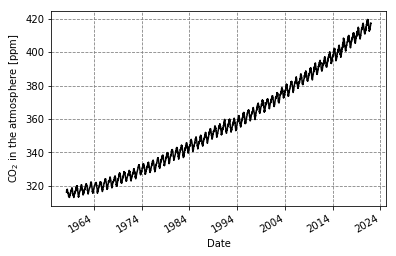

In [47]:
ax = new_data["CO2"].plot(color="black", linestyle="-")
ax.set_ylabel(r"$\rm CO_2$ in the atmosphere [ppm]")
ax.grid(linestyle="--", linewidth=0.8, color="gray")

Nous observons bien une oscillation périodique superposée à une évolution systématique plus lente.
A présent nous pouvons essayer de déterminer la période d'oscillation.

Dans la suite, nous cherchons à séparer ces deux contributions. L'augmentation systématique de la teneur en oxygène $\rm CO_2$ est etimée à partir d'une fonction polyomiale de degré 2 et d'équation: $y = a_2 x^2 + a_1 x + a_0$.

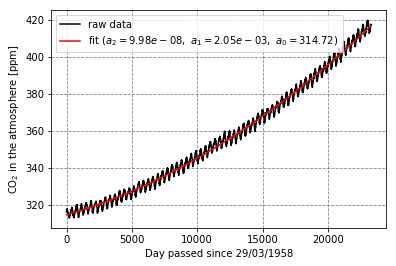

In [50]:
x = new_data["Day_number"]
y = new_data["CO2"]

coeff = np.polyfit(x, y, 2)
y_fit = np.polyval(coeff, x)
new_data["Incr_trend"] = y_fit

plt.figure()
plt.plot(x, y, color="black", linestyle="-", label="raw data")
plt.plot(x, y_fit, color="red", linestyle="-", label=r"fit ($a_2={0:.2e},\ a_1={1:.2e},\ a_0={2:.2f}$)".format(*coeff))

plt.xlabel("Day passed since {:%d/%m/%Y}".format(new_data.index[0]))
plt.ylabel(r"$\rm CO_2$ in the atmosphere [ppm]")
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.legend()

plt.show()

Dans la suite, nous soustrayons la contribution systématique des données brutes afin de ne garder que la composante oscillatoire.

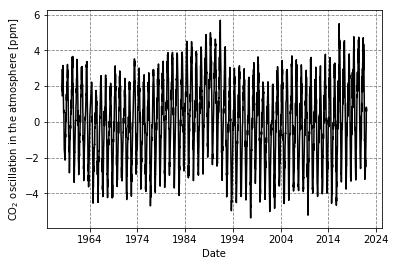

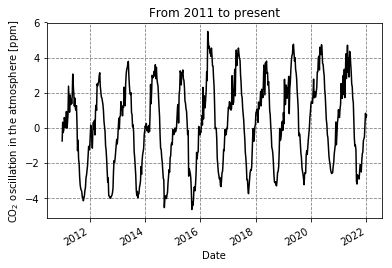

In [46]:
y_new = y - y_fit
new_data["CO2_osc"] = y_new

plt.figure()
plt.plot(new_data.index, y_new, color="black", linestyle="-")
plt.xlabel("Date")
plt.ylabel(r"$\rm CO_2$ oscillation in the atmosphere [ppm]")
plt.grid(linestyle="--", linewidth=0.8, color="gray")

plt.figure()
new_data["CO2_osc"]["2011":].plot(color="black", linestyle="-")
plt.xlabel("Date")
plt.ylabel(r"$\rm CO_2$ oscillation in the atmosphere [ppm]")
plt.title("From 2011 to present")
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.xlim()

plt.show()

Nous pouvons réaliser une transformée de Fourier au signal précédemment obtenu afin de déterminer les fréquences qui lui sont associées.

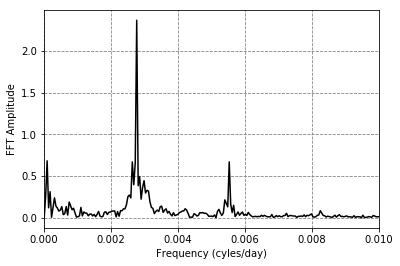

In [30]:
N = len(y_new)
T = 7 # time step in day

X = fft(y_new)[0:N//2]
freq = fftfreq(N, T)[:N//2] # [cycles/day]
amp = 2.0/N * np.abs(X)

plt.plot(freq, amp, color="black", linestyle="-")
plt.xlabel('Frequency (cyles/day)')
plt.ylabel('FFT Amplitude')
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.xlim(left=0, right=1e-2)

plt.show()

Nous nous intéressons maintenant aux fréquences de plus fortes amplitudes. Le contenu ci-dessous permet d'obtenir les trois fréquences de plus fortes amplitudes. Ces dernières sont représentées en rouge sur le graphique ci-dessous.

[2.76327909e-03 8.77231458e-05 5.52655818e-03]
[  361.88888889 11399.5          180.94444444]


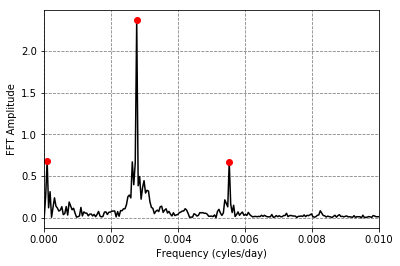

In [54]:
_sort_id = np.argsort(amp)
ampMax = amp[_sort_id][::-1][:3:]
freqMax = freq[_sort_id][::-1][:3:]

print(freqMax)
print(1/freqMax)

plt.plot(freq, amp, color="black", linestyle="-")
plt.plot(freqMax, ampMax, color="red", linestyle="", marker="o")
plt.xlabel('Frequency (cyles/day)')
plt.ylabel('FFT Amplitude')
plt.grid(linestyle="--", linewidth=0.8, color="gray")
plt.xlim(left=0, right=1e-2)

plt.show()

Si l'on s'intéresse à la fréquence dont l'amplitude est maximale, cela correspond à un cycle tous les 362 jours environs. La seconde fréquence a peu de sens, dans la mesure où cette dernière est obtenu à très faible fréquence et provient probablement d'un artefact de calcul.